In [1]:
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from transformers import TFAutoModel, RobertaTokenizer
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [3]:
train = pd.read_csv('../input/druginteraction/train.csv')
valid = pd.read_csv('../input/druginteraction/valid.csv')
test = pd.read_csv('../input/druginteraction/test.csv')
labels = pd.read_csv('../input/druginteraction/labels.csv')

In [4]:
seq_len = 128
num_sample_train = len(train)
num_sample_valid = len(valid)
num_sample_test = len(test)

xtrain_drug1 = train['Drug1']
xtrain_drug2 = train['Drug2']
xtrain_y = train['label']

xtest_drug1 = test['Drug1']
xtest_drug2 = test['Drug2']
xtest_y = test['label']

xvalid_drug1 = valid['Drug1']
xvalid_drug2 = valid['Drug2']
xvalid_y = valid['label']

In [5]:
tokenizer = RobertaTokenizer.from_pretrained('DeepChem/ChemBERTa-77M-MLM')

Downloading:   0%|          | 0.00/6.80k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/631 [00:00<?, ?B/s]

In [6]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks = [],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=seq_len, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=False)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [7]:
xtrain_drug1, xtrain_drug1_mask = tokenize(list(xtrain_drug1), tokenizer = tokenizer)
xtrain_drug2, xtrain_drug2_mask = tokenize(list(xtrain_drug2), tokenizer = tokenizer)

xvalid_drug1, xvalid_drug1_mask = tokenize(list(xvalid_drug1), tokenizer=tokenizer)
xvalid_drug2, xvalid_drug2_mask = tokenize(list(xvalid_drug2), tokenizer=tokenizer)

xtest_drug1, xtest_drug1_mask = tokenize(list(xtest_drug1), tokenizer=tokenizer)
xtest_drug2, xtest_drug2_mask = tokenize(list(xtest_drug2), tokenizer=tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [8]:
input_shape = xtrain_drug1.shape[1]
output_shape = len(labels)

In [9]:
print(input_shape)
print(output_shape)

128
86


In [10]:
Drug1_model = TFAutoModel.from_pretrained('DeepChem/ChemBERTa-77M-MLM', from_pt = True)
Drug2_model = TFAutoModel.from_pretrained('DeepChem/ChemBERTa-77M-MLM', from_pt = True)

Downloading:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

2022-05-29 18:24:18.035079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 18:24:18.036195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 18:24:18.036840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 18:24:18.037738: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
def model(input_shape, output_shape):
    input_ids_drug1 = layers.Input(shape=(input_shape,), name = "input_ids_drug1", dtype = 'int32')
    input_ids_drug2 = layers.Input(shape=(input_shape,), name = "input_ids_drug2", dtype = 'int32')

    input_mask_drug1 = layers.Input(shape=(input_shape,), name = "input_mask_drug1")
    input_mask_drug2 = layers.Input(shape=(input_shape,), name = "input_mask_drug2")

    embed1 = Drug1_model([input_ids_drug1, input_mask_drug1])[1]

    embed2 = Drug2_model([input_ids_drug2, input_mask_drug2])[1]
    d1 = layers.Dense(1024, activation = 'relu')(embed1)
    d1 = layers.Dense(512, activation = 'relu')(d1)
    d2 = layers.Dense(1024, activation = 'relu')(embed2)
    d2 = layers.Dense(512, activation = 'relu')(d2)

    dtot = layers.Concatenate()([d1,d2])
    d3 = layers.Dense(1024, activation = 'relu')(dtot)
    d3 = layers.Dense(512, activation = 'relu')(d3)
    d3 = layers.Dense(256, activation = 'relu')(d3)
    d3 = layers.Dense(output_shape, activation = 'softmax')(d3)

    model = Model(inputs = [input_ids_drug1,input_ids_drug2,input_mask_drug1,input_mask_drug2], outputs = d3)
    return model

In [12]:
model_train = model(input_shape, output_shape)
model_train.layers[4].trainable = False
model_train.layers[5].trainable = False
model_train.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids_drug1 (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask_drug1 (InputLayer)   [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_ids_drug2 (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask_drug2 (InputLayer)   [(None, 128)]        0                                            
______________________________________________________________________________________________

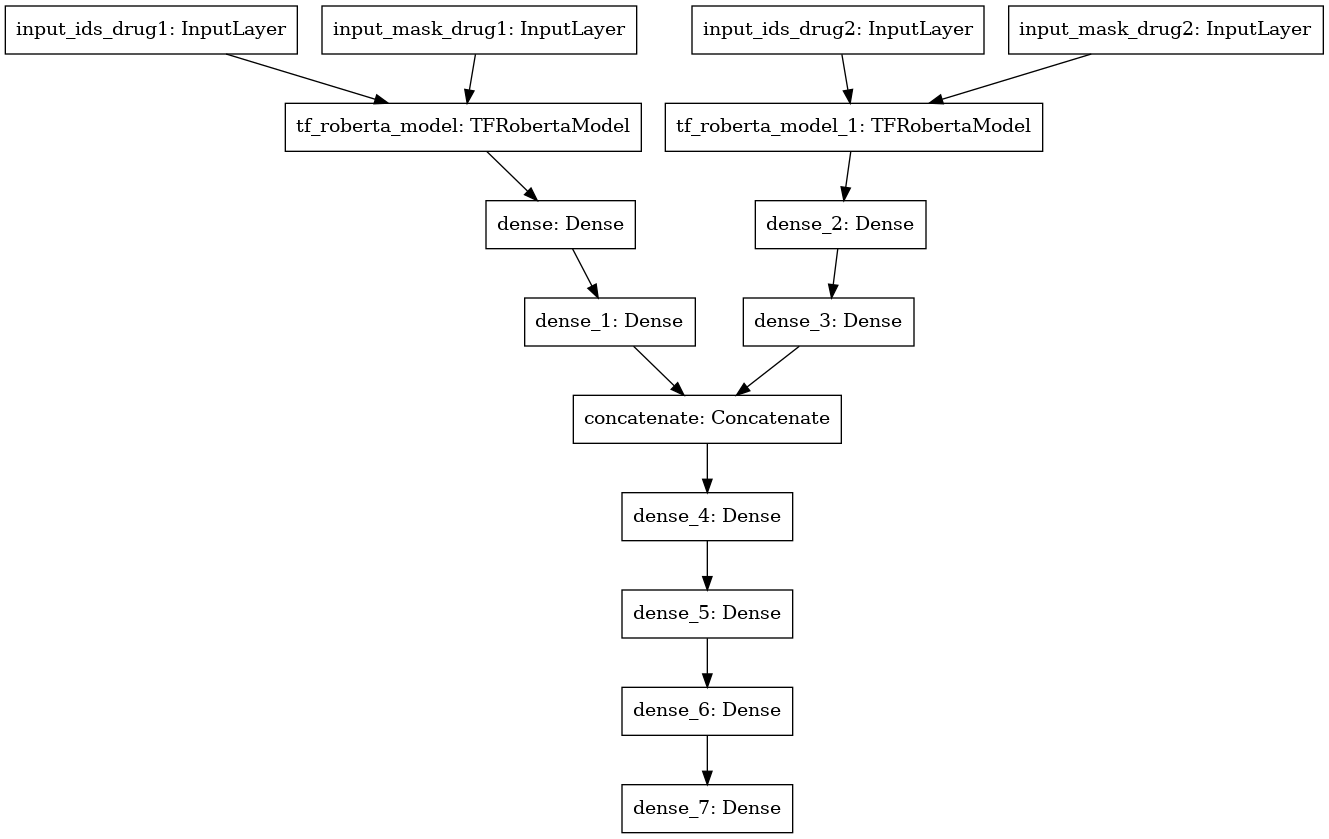

In [13]:
plot_model(model_train)

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model_train.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [15]:
checkpoint_filepath = './checkpoint'
best_model = ModelCheckpoint(filepath = checkpoint_filepath, monitor = 'val_accuracy', save_best_only=True, save_weights_only = True, mode='max')

rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, min_delta=1e-5)


In [16]:
history = model_train.fit([xtrain_drug1, xtrain_drug2, xtrain_drug1_mask, xtrain_drug2_mask], xtrain_y
                    ,validation_data =([xvalid_drug1,xvalid_drug2, xvalid_drug1_mask, xvalid_drug2_mask],xvalid_y),
                     epochs = 120, callbacks=[rlr, best_model], batch_size=256)

2022-05-29 18:24:33.085287: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/120
600/600 [==============================] - 136s 216ms/step - loss: 1.8546 - accuracy: 0.4845 - val_loss: 1.1356 - val_accuracy: 0.6614
Epoch 2/120
600/600 [==============================] - 128s 213ms/step - loss: 1.0680 - accuracy: 0.6699 - val_loss: 0.8031 - val_accuracy: 0.7488
Epoch 3/120
600/600 [==============================] - 128s 213ms/step - loss: 0.7966 - accuracy: 0.7403 - val_loss: 0.5923 - val_accuracy: 0.8000
Epoch 4/120
600/600 [==============================] - 128s 213ms/step - loss: 0.6467 - accuracy: 0.7824 - val_loss: 0.4607 - val_accuracy: 0.8474
Epoch 5/120
600/600 [==============================] - 128s 213ms/step - loss: 0.5511 - accuracy: 0.8107 - val_loss: 0.4112 - val_accuracy: 0.8613
Epoch 6/120
600/600 [==============================] - 128s 213ms/step - loss: 0.4828 - accuracy: 0.8319 - val_loss: 0.3836 - val_accuracy: 0.8733
Epoch 7/120
600/600 [==============================] - 128s 213ms/step - loss: 0.4338 - accuracy: 0.8475 - val_loss: 0

In [17]:
model_check = model(input_shape, output_shape)

In [18]:
model_check.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [19]:
model_check.load_weights(checkpoint_filepath)

In [20]:
model_check.evaluate([xtest_drug1, xtest_drug2, xtest_drug1_mask, xtest_drug2_mask], xtest_y)

600/600 [==============================] - 19s 30ms/step - loss: 0.2891 - accuracy: 0.9515


[0.2890872061252594, 0.9515145421028137]

In [21]:
model_check.evaluate([xvalid_drug1,xvalid_drug2, xvalid_drug1_mask, xvalid_drug2_mask],xvalid_y)

600/600 [==============================] - 18s 30ms/step - loss: 0.2646 - accuracy: 0.9530


[0.26458483934402466, 0.9529743194580078]

In [22]:
"""import shutil
shutil.make_archive('model.tf', 'zip', './model1.tf')"""

"import shutil\nshutil.make_archive('model.tf', 'zip', './model1.tf')"